# TRAINING JUPYTER

## I) DATA

### Data Loading

In [1]:
from generator import generate_conv
from preprocess import DictPrepross, Zero_One, Normalizer
from netCDF4 import Dataset
import numpy as np
import os

datafolder ='Data'
fin = Dataset(os.path.join(datafolder, 'f522_dh.trainingdata_in.lcv.20190401_0000z.nc4'))
fout = Dataset(os.path.join(datafolder, 'f522_dh.trainingdata_out.lcv.20190401_0000z.nc4'))
x = fin.variables
y = fout.variables
n,p = x['Xdim'].shape[0],x['Ydim'].shape[0]

### Parameter setting

In [2]:
batch_size = 64  # size of batch
header = list(x.keys())[6:]  # variables are relevant after "time"
kernels = [] # list of kernels
testprop = 0.9 # proportion of test data
seed = 0;  np.random.seed(seed); # setting the seed

 Creation of the preprocessor to normalize the data

In [3]:

header_dict = ["ql","qi","q","rl","ri","ts","t", "pl","emis","o3"]  # variable we preprocess
fct = [] # how to preprocess them
for i in range(5):
    fct.append(Zero_One())
for j in range(5):
    fct.append(Normalizer())
    
D = DictPrepross(header_dict, fct)
del(fct)
D.fitonNetCDF(x)

fix parameters

In [4]:
d = len(header) + np.sum(np.array( [len(k.header) for k in kernels]  ))
batch_per_epoch = int(n*p / batch_size)

In [ ]:
d
    
    
    

In [5]:
def generate_rnn(x, y, kernels, train_prop=0.9, header=['ql'], batch_size=16, preprocess=DictPrepross([], []),
                  maxbatch=-1, test_data=False):
    """"
    Generate a batch, randomly for a convolution NN, using only variable in header

    x : input data in NetCDF format
    y : output data in NetCDF format
    kernels : list of kernsl
    train_prop : proportion of the training set
    header : variable used
    batch_size : size of the generated batch
    preprocess : DictPrepross object to apply to the data
    maxbatch : number of batch produced, maxbacth<0 means an infinite number of batch
    """

    maxbatch = int(maxbatch)
    n = x['Xdim'].shape[0]
    nt = int(n * train_prop)  # id up to training
    p = x['Ydim'].shape[0]
    lev = x['lev'].shape[0]

    x_header = header
    x_header.sort()

    nbatch = 0
    while nbatch != maxbatch:
        y_shuffled = np.arange(p)  # Ydim id to be shuffled
        # Xdim id but to be shuffled
        if test_data:
            x_shuffled =  np.arange(n - nt)  # test
            x_max = n  # Xdim not to outgrow
        else:
            x_shuffled = np.arange(nt)  # train
            x_max = nt  # Xdim not to outgrow

#        np.random.shuffle(y_shuffled) #shuffling y divide the speed by 3
        np.random.shuffle(x_shuffled)

        id_batches_x = 0  # counting the id for batches coordinates
        id_batches_y = 0
        while id_batches_x < x_max and nbatch != maxbatch:

            nbatch += 1
            data_x = np.zeros((batch_size, lev+1, 1))  # batch data
            idn = x_shuffled[id_batches_x]  # chosen indice in X_dim
            idp = y_shuffled[id_batches_y + np.arange(batch_size)]  # chosen indices in Y_dim

            Y = y['flx'][0, :, idp, idn]
            Y = Y.swapaxes(0, 1)
            for k in x_header:
                addvect = np.zeros((batch_size,lev+1, 1))
                if len(x[k].shape) == 4:
                    a = x[k][:, :, idp, idn]
                    a = a.reshape(1, lev, -1)
                    a = a.swapaxes(0, 2)
                    addvect[:, :-1] = a
                    addvect[:,  -1] = addvect[:, -2]
                    addvect = preprocess.apply(addvect, k)
                elif len(x[k].shape) == 3:
                    a = x[k][:, idp, idn]
                    a = a.repeat(lev, 1).reshape(1, -1, lev)
                    a = a.swapaxes(0, 1)
                    a = a.swapaxes(1, 2)
                    addvect[:, :-1] = a
                    addvect[:,  -1] = addvect[:, -2]
                    addvect = preprocess.apply(addvect, k)
                    addvect[:, :-1] = 0

                data_x = np.concatenate((data_x, addvect), axis=2)
            data_x = data_x[:, :, 1:]  # the first channel is full of 0, thus eliminated
            for k in kernels:
                data_x = k.apply(data_x, x_header)

            yield data_x, Y

            id_batches_y += batch_size
            if id_batches_y + batch_size >= p:
                id_batches_y = 0
                id_batches_x += 1


## II) ARCHITECTURES

### Bidir RNN followed by fcn

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, SimpleRNN, GRU, Activation, Flatten, Conv1D
from keras import optimizers
from keras.layers import Bidirectional
from keras import backend as K


modelbd = Sequential()
modelbd.add(Bidirectional(LSTM(128, return_sequences=True, use_bias=False),input_shape=(73, 11)))
modelbd.add(Conv1D(50, use_bias=False,kernel_size=10 ,padding='same'))
modelbd.add(Activation('relu'))
modelbd.add(Conv1D(20, kernel_size=3 ,padding='same'))
modelbd.add(Activation('relu'))
modelbd.add(Dense(1))
modelbd.add(Flatten())

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1.e-5)
modelbd.compile(loss='mse', optimizer=rmsprop)
modelbd.summary()

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 73, 256)           142336    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 73, 50)            128000    
_________________________________________________________________
activation_1 (Activation)    (None, 73, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 73, 20)            3020      
_________________________________________________________________
activation_2 (Activation)    (None, 73, 20)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 73, 1)             21        
_________________________________________________________________
flatten_1 (Flatten)          (None, 73)                0         
Total para

In [61]:
73*256*3

56064

In [7]:
train_generator =  lambda Params, batch_size, nb=-1 : generate_rnn( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb,  preprocess=D, test_data=False)

test_generator = lambda Params, batch_size, nb=1 : generate_rnn( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb, preprocess=D, test_data=True)

In [8]:
testsize = 128*4
for x0,y0 in test_generator( (x,y), batch_size=testsize, nb=1):
    data_test = (x0,y0)
import datetime
import os

model_folder = "TrainedModels"
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "Bidir"
if not os.path.isdir(model_folder):
    os.mkdir(model_folder)    

In [10]:
if len(K.tensorflow_backend._get_available_gpus())>0:
    history = modelbd.fit_generator( train_generator( (x, y), batch_size=64),steps_per_epoch=50, epochs=10, validation_data=data_test)
    modelbd.save(  os.path.join(model_folder, prefix+archi+'.h5')  )

Epoch 1/10
50/50 [==============================] - 69s 1s/step - loss: 11979.6864 - val_loss: 6837.8639
Epoch 2/10
50/50 [==============================] - 66s 1s/step - loss: 4148.8606 - val_loss: 4085.1532
Epoch 3/10
50/50 [==============================] - 67s 1s/step - loss: 4054.6887 - val_loss: 4116.5466
Epoch 4/10
50/50 [==============================] - 66s 1s/step - loss: 3190.6325 - val_loss: 10933.1103
Epoch 5/10
50/50 [==============================] - 67s 1s/step - loss: 3623.9921 - val_loss: 4110.5503
Epoch 6/10
50/50 [==============================] - 67s 1s/step - loss: 3081.3177 - val_loss: 8004.2000
Epoch 7/10
50/50 [==============================] - 67s 1s/step - loss: 2412.1520 - val_loss: 3661.3252
Epoch 8/10
50/50 [==============================] - 70s 1s/step - loss: 2424.5442 - val_loss: 3924.9442
Epoch 9/10
50/50 [==============================] - 68s 1s/step - loss: 2075.0923 - val_loss: 5363.4121
Epoch 10/10
50/50 [==============================] - 68s 1s/st

### VISUALISATION

In [9]:
from keras.models import load_model
import matplotlib.pyplot as plt

In [10]:
models=[]
ytruth = data_test[1]
for weight in os.listdir("TrainedModels/"):
    models.append(load_model(os.path.join("TrainedModels",weight)))
    ypred  = models[-1].predict(data_test[0])
    print(weight, np.sqrt(np.sum(np.square(ypred-ytruth)))/testsize)
    break

20190502144012Bidir.h5 25.947925567626953


In [20]:
import matplotlib.pyplot as plt

def multipred(models,x):
    bs = x.shape[0]
    yp = np.zeros((len(models),bs,73))
    for i,model in enumerate(models):
        yp[i,:,:]=model.predict(x)
    return(yp)

testsize = 128*4
for x0,y0 in test_generator( (x,y), batch_size=testsize, nb=1):
    data_test = (x0,y0)

ytruth = data_test[1]
xtest = data_test[0].copy() 
xtest1 = data_test[0].copy() 
xtest2 = data_test[0].copy()
xtest3 = data_test[0].copy()

xtest1 *=0
xtest2[:,:,1] *= 0
xtest3[:,:,2] *= 0

ypred = multipred(models,xtest)
ypred1 = multipred(models,xtest1)
ypred2 = multipred(models,xtest2)
ypred3 = multipred(models,xtest3)

48


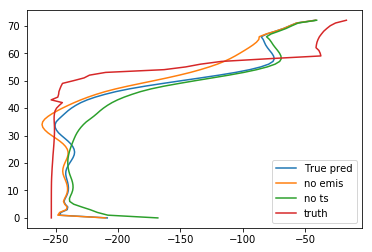

In [22]:
i=np.random.randint(testsize)
print(i)

f=plt.figure()
ax = f.add_subplot(111)
ax.plot(ypred[0,i],np.arange(73), label="True pred");
#ax.plot(ypred1[0,i],np.arange(73), label="0");
ax.plot(ypred2[0,i],np.arange(73), label="no emis");
ax.plot(ypred3[0,i],np.arange(73), label="no ts");
ax.plot(ytruth[i],np.arange(73), label="truth");
ax.legend()

158


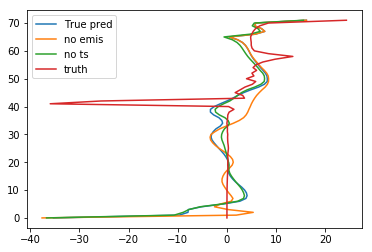

In [25]:
i=np.random.randint(testsize)
print(i)

def diff(y):
    return( y[1:] - y[:-1])


f=plt.figure()
ax = f.add_subplot(111)
ax.plot(diff(ypred[0,i]),np.arange(72), label="True pred");
ax.plot(diff(ypred2[0,i]),np.arange(72), label="no emis");
ax.plot(diff(ypred3[0,i]),np.arange(72), label="no ts");
ax.plot(diff(ytruth[i]),np.arange(72), label="truth");
ax.legend();

In [13]:
m = models[0]
m.layers[0]

In [ ]:
import keras.backend as K

def double_mean_squared(y_true, y_pred):
    fist_loss   =  K.mean(K.square(y_pred - y_true), axis=-1)
    second_loss =  x[:, :1]
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
return K.mean(K.square(first_log - second_log), axis=-1)



In [14]:
for i in  m.get_weights():
    print(i.shape)

(11, 512)
(128, 512)
(11, 512)
(128, 512)
(10, 256, 50)
(3, 50, 20)
(20,)
(20, 1)
(1,)


In [80]:
128*4

512

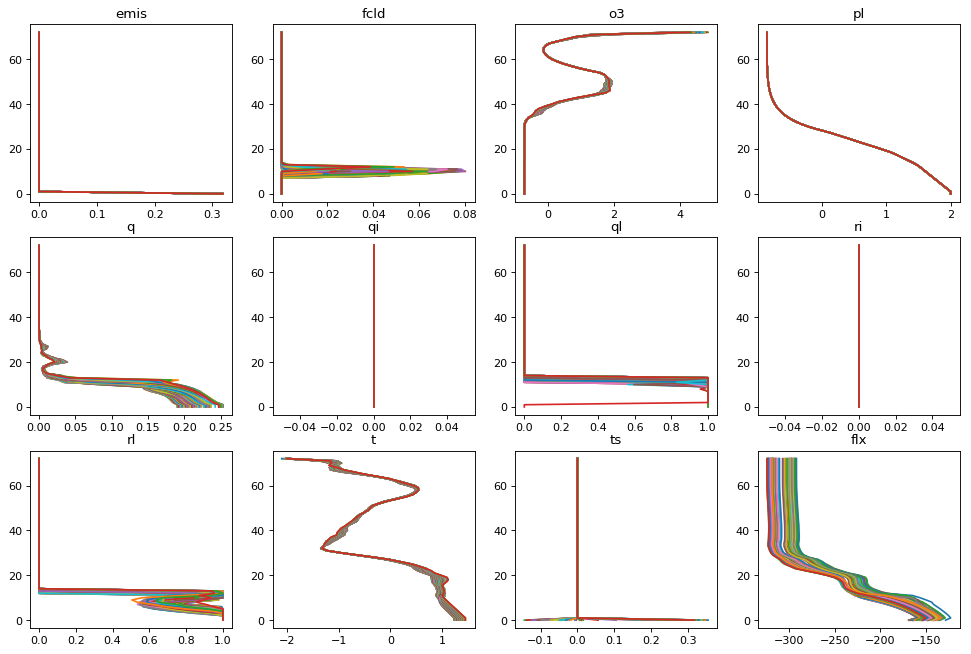

In [15]:
np.random.seed(0)
f=plt.figure( figsize=(15,10), dpi=80)
for x0,y0 in train_generator((x,y), batch_size=64, nb=1):
    for i in range(11):
        ax= f.add_subplot(3,4,i+1)
        ax.set_title(header[i])
        for b in range(x0.shape[0]):
            ax.plot(np.flip(x0[b,:,i]), np.arange(73))
    ax= f.add_subplot(3,4,12)
    ax.set_title('flx')
    for b in range(y0.shape[0]):
        ax.plot(np.flip(y0[b]), np.arange(73))

plt.show();

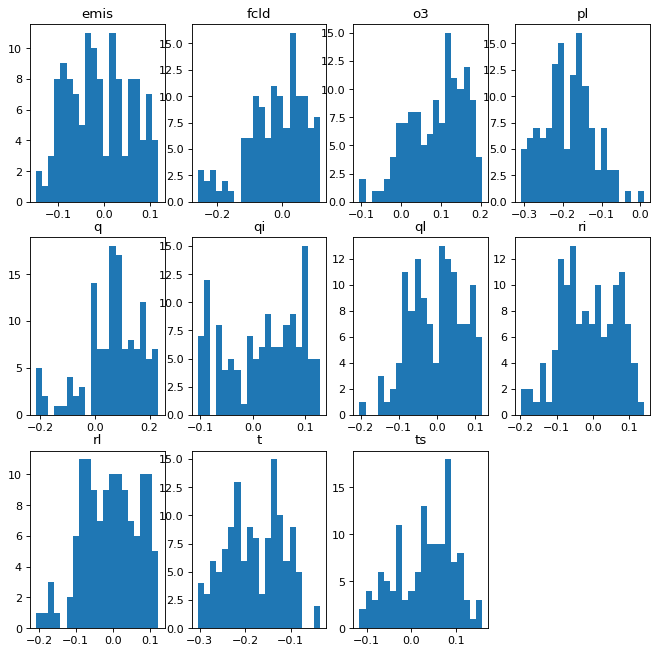

In [120]:
f=plt.figure( figsize=(10,10), dpi=80)
for i in range(11):
    ax= f.add_subplot(3,4,i+1)
    wi = m.get_weights()[0][i,:128]
#    wi.sort()
    ax.hist(wi, bins=20)
    ax.set_title(header[i])    

In [99]:
from keras import backend as K

inp = m.input                                           # input placeholder
outputs = [layer.output for layer in m.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
input_shape = (73,11)
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test, 1.]) for func in functors]
print(layer_outs)

AttributeError: 'int' object has no attribute 'dtype'

<tf.Variable 'Variable:0' shape=() dtype=float32_ref>

In [104]:
K.set_learning_phase(K.variable(0))
K.learning_phase()

ValueError: Expected learning phase to be 0 or 1.

In [23]:
models[0].summary()
l = models[0].get_layer("dense_5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 73, 256)           143360    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 73, 50)            128050    
_________________________________________________________________
activation_9 (Activation)    (None, 73, 50)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 73, 20)            3020      
_________________________________________________________________
activation_10 (Activation)   (None, 73, 20)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 73, 1)             21        
_________________________________________________________________
flatten_2 (Flatten)          (None, 73)                0         
Total para

In [24]:
l.weights

[<tf.Variable 'dense_5_1/kernel:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'dense_5_1/bias:0' shape=(1,) dtype=float32_ref>]

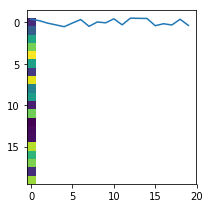

In [35]:

l = models[0].get_layer("dense_5")
w_v = get_value(l.weights[0])
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
plt.imshow(w_v)
ax.set_aspect('equal')

plt.plot(w_v);

In [38]:
get_value(l.weights[1])

array([-0.04043192], dtype=float32)

### SECOND ARCHITECTURE :
Not tested yet

In [3]:
def CreateConv1D(n_unit, kernel_size, reg=0, seed=0, inputsize=False):
    if not inputsize:
        return(Conv1D(filters=n_unit, kernel_size=kernel_size, \
                 kernel_regularizer=regularizers.l2(reg), \
                 padding="same", kernel_initializer = initializers.normal(seed=seed)))
    else:
        return(Conv1D(input_shape=inputsize, filters=n_unit, kernel_size=kernel_size, \
                 kernel_regularizer=regularizers.l2(reg), \
                 padding="same", kernel_initializer = initializers.normal(seed=seed)))
        

def CreateModel(Hn, Ks, inputsize, reg=0, seed=0):
    model = Sequential()
    model.add(CreateConv1D(Hn[0], Ks[0], reg, seed, inputsize))
    model.add(Activation("relu"))
    for i in range(1,len(Hn)-1):
        model.add(GenerateConv1D(Hn[i], Ks[i], reg, seed, False))
        model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(73, kernel_regularizer = regularizers.l2(0.01),\
                kernel_initializer = initializers.normal(seed=s)))
    return(model)

HNn = [128,64,16,4] # hidden layer size
Ks = [10, 10, 3, 3]
inputsize = (lev, d)

model = CreateModel(HNn, Ks, inputsize, 0.01)

sgd = optimizers.SGD(lr=0., decay=1e-6, momentum=0.95)

model.compile(optimizer=sgd,
             loss='mse',
             )
model.save('arch1_FCNN.h5')

In [2]:
# PARAMETERS 
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Activation,Input,Flatten, UpSampling1D
from keras import optimizers, regularizers, initializers

# PARAMETERS :
batch_size = 64
header = list(x.keys())[6:] # variables are relevant after "time"
kernels = []
testprop = 0.9
s = 0
np.random.seed(s)

n,p, lev = x['Xdim'].shape[0],x['Ydim'].shape[0],x['lev'].shape[0]

d = len(header) + np.sum(np.array( [len(k.header) for k in kernels]  )).astype(int)
batch_per_epoch = int(n*p / batch_size)
batch_generator = lambda Params, batch_size : generate_conv( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# III) TRACKS 

### MODEL 2 :

- FCNN
- (with AE)

##### MODEL 2 : FCM-Final FC

##### MODEL 2 : U-net :
- use regular U-net so all layers affect each other and more stability

### MODEL 3 : Bidir-LSTM 
> Possible alternatives

- use two LSTM to show both impact of superior and inferior layer
- use attention model over it
- use w embeddings before

> TD

- Read git trez
- Read article of Hedge fun